# 📈 04 - Forecasting Model: Predicting Future Energy Prices
This notebook trains a time-aware forecasting model using only **past and known features** to predict future energy prices.
- No real-time values (e.g., solar, wind, gas/oil) from the target hour are used.
- Only lagged features, calendar info, and past trends are included.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()
df.head()

,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_wind_capacity,DE_wind_generation_actual,Price (EUR/MWhe),DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,Gas_Price,Oil_Price
utc_timestamp,,,,,,,,,,,,
2014-12-31 23:00:00,2015-01-01T00:00:00+0100,NaN,37248.0,0.0,27913.0,NaN,NaN,NaN,NaN,NaN,3.14,55.38
2015-01-01 00:00:00,2015-01-01T01:00:00+0100,41151.0,37248.0,0.0,27913.0,8852.0,22.34,-0.981,0.0,0.0,3.14,55.38
2015-01-01 01:00:00,2015-01-01T02:00:00+0100,40135.0,37248.0,0.0,27913.0,9054.0,22.34,-1.035,0.0,0.0,3.14,55.38
2015-01-01 02:00:00,2015-01-01T03:00:00+0100,39106.0,37248.0,0.0,27913.0,9070.0,22.34,-1.109,0.0,0.0,3.14,55.38
2015-01-01 03:00:00,2015-01-01T04:00:00+0100,38765.0,37248.0,0.0,27913.0,9163.0,22.34,-1.166,0.0,0.0,3.14,55.38


## 🔧 Feature Engineering: Past-Only + Calendar Features

In [2]:
# Target variable
target = 'Price (EUR/MWhe)'

# Lag features (price only)
df['price_lag_1h'] = df[target].shift(1)
df['price_lag_24h'] = df[target].shift(24)
df['price_lag_168h'] = df[target].shift(168)

# Rolling averages
df['price_roll_24h'] = df[target].rolling(24).mean()
df['price_roll_168h'] = df[target].rolling(168).mean()

# Calendar features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Final feature set
features = [
    'price_lag_1h', 'price_lag_24h', 'price_lag_168h',
    'price_roll_24h', 'price_roll_168h',
    'hour', 'dayofweek', 'month'
]

# Drop NA rows (caused by lag/rolling)
df_model = df[features + [target]].dropna()

## 📆 Time-Based Train-Test Split (Forecast Style)

In [3]:
# Train on 2015-2018, test on 2019
train = df_model[df_model.index < '2019-01-01']
test = df_model[df_model.index >= '2019-01-01']

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

## 🚀 Train Forecasting Model with XGBoost

In [4]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 📊 Evaluate the Forecast

In [5]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 2.00
RMSE: 3.36


## 📉 Plot Actual vs Forecasted Prices

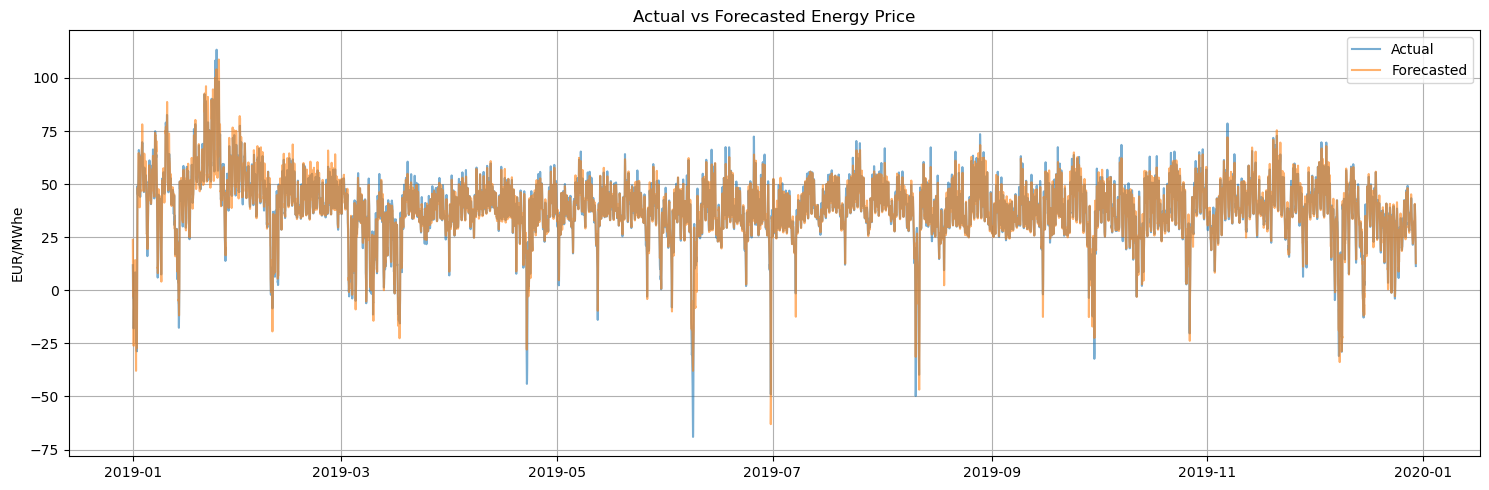

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.6)
plt.plot(y_test.index, y_pred, label='Forecasted', alpha=0.6)
plt.title('Actual vs Forecasted Energy Price')
plt.ylabel('EUR/MWhe')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

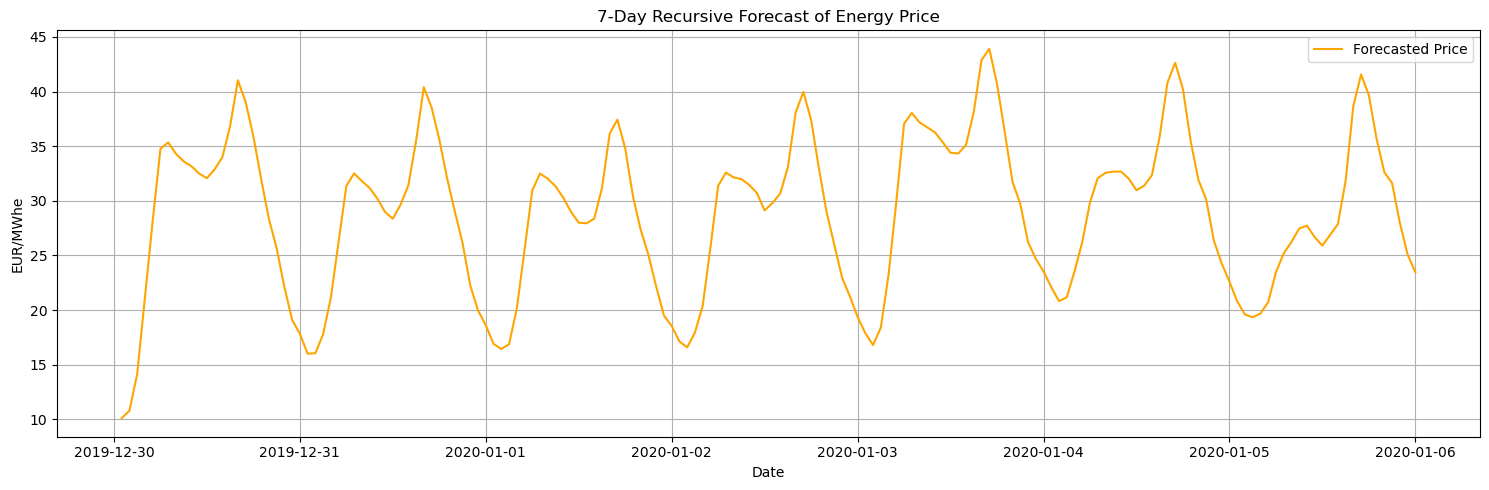

In [8]:
from datetime import timedelta

# Copy the latest known data (last row of full df_model) as our starting point
last_known = df_model.copy().iloc[-200:].copy()

# Prepare an empty DataFrame to hold future predictions
future_predictions = []

# Set the number of hours to forecast (7 days = 168 hours)
forecast_horizon = 168

for step in range(1, forecast_horizon + 1):
    next_timestamp = last_known.index[-1] + timedelta(hours=1)

    # Create next row
    new_row = {
        'price_lag_1h': last_known[target].iloc[-1],  # last predicted or real price
        'price_lag_24h': last_known[target].shift(23).iloc[-1] if len(last_known) >= 24 else np.nan,
        'price_lag_168h': last_known[target].shift(167).iloc[-1] if len(last_known) >= 168 else np.nan,
        'price_roll_24h': last_known[target].rolling(24).mean().iloc[-1] if len(last_known) >= 24 else np.nan,
        'price_roll_168h': last_known[target].rolling(168).mean().iloc[-1] if len(last_known) >= 168 else np.nan,
        'hour': next_timestamp.hour,
        'dayofweek': next_timestamp.dayofweek,
        'month': next_timestamp.month
    }

    new_row_df = pd.DataFrame([new_row], index=[next_timestamp])
    
    # Drop if any NaNs exist (optional)
    if new_row_df.isnull().any(axis=1).iloc[0]:
        print(f"Insufficient history at step {step}, skipping forecast.")
        break

    # Predict next price
    prediction = model.predict(new_row_df[features])[0]

    # Add prediction to the new_row_df
    new_row_df[target] = prediction

    # Append to results
    future_predictions.append(new_row_df)

    # Add to last_known so it can be used in future steps
    last_known = pd.concat([last_known, new_row_df])

# Combine all predicted rows
future_df = pd.concat(future_predictions)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(future_df.index, future_df['Price (EUR/MWhe)'], label='Forecasted Price', color='orange')
plt.title('7-Day Recursive Forecast of Energy Price')
plt.xlabel('Date')
plt.ylabel('EUR/MWhe')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


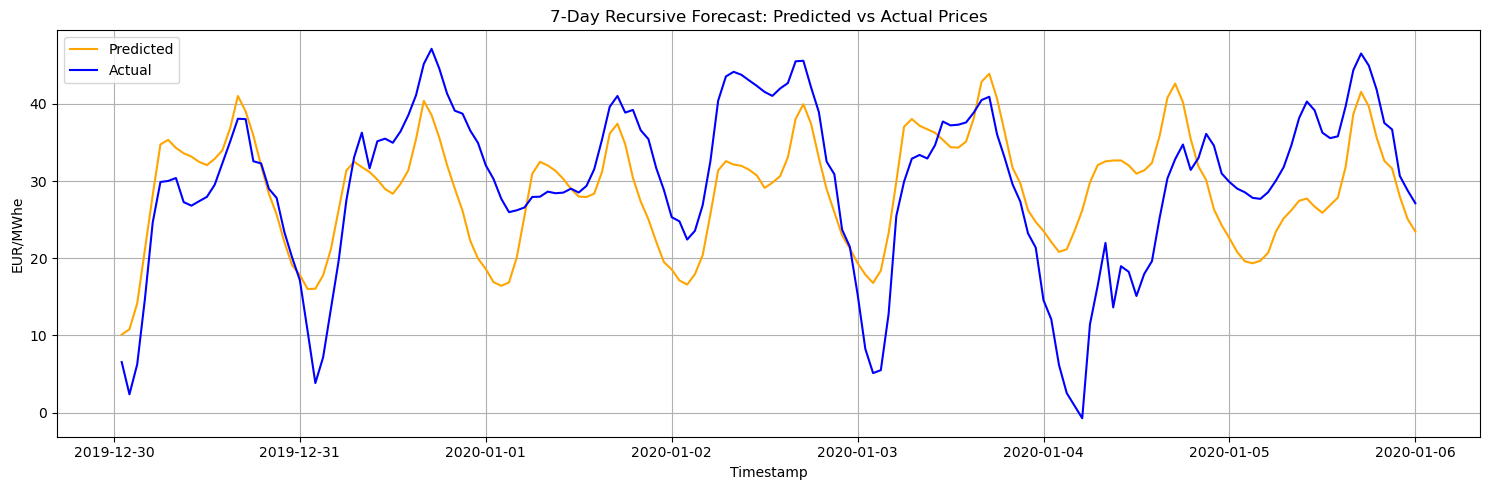

Forecast MAE: 6.97
Forecast RMSE: 8.35


In [10]:
# Load full price data to get actual future values
df_prices = pd.read_csv('../data/raw/Germany.csv', parse_dates=['Datetime (UTC)'])
df_prices.set_index('Datetime (UTC)', inplace=True)
df_prices = df_prices.sort_index()

# Extract actual prices for the forecasted range
actual_prices = df_prices.loc[future_df.index, 'Price (EUR/MWhe)'].dropna()

# Combine with predictions
comparison_df = future_df[['Price (EUR/MWhe)']].rename(columns={'Price (EUR/MWhe)': 'Predicted'})
comparison_df['Actual'] = actual_prices

# Drop rows without matching actual data
comparison_df.dropna(inplace=True)

# Plot comparison
plt.figure(figsize=(15, 5))
plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', color='orange')
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', color='blue')
plt.title('7-Day Recursive Forecast: Predicted vs Actual Prices')
plt.xlabel('Timestamp')
plt.ylabel('EUR/MWhe')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
mae = mean_absolute_error(comparison_df['Actual'], comparison_df['Predicted'])
rmse = np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['Predicted']))

print(f"Forecast MAE: {mae:.2f}")
print(f"Forecast RMSE: {rmse:.2f}")



🔮 Forecasting: 1d (24 hours)...


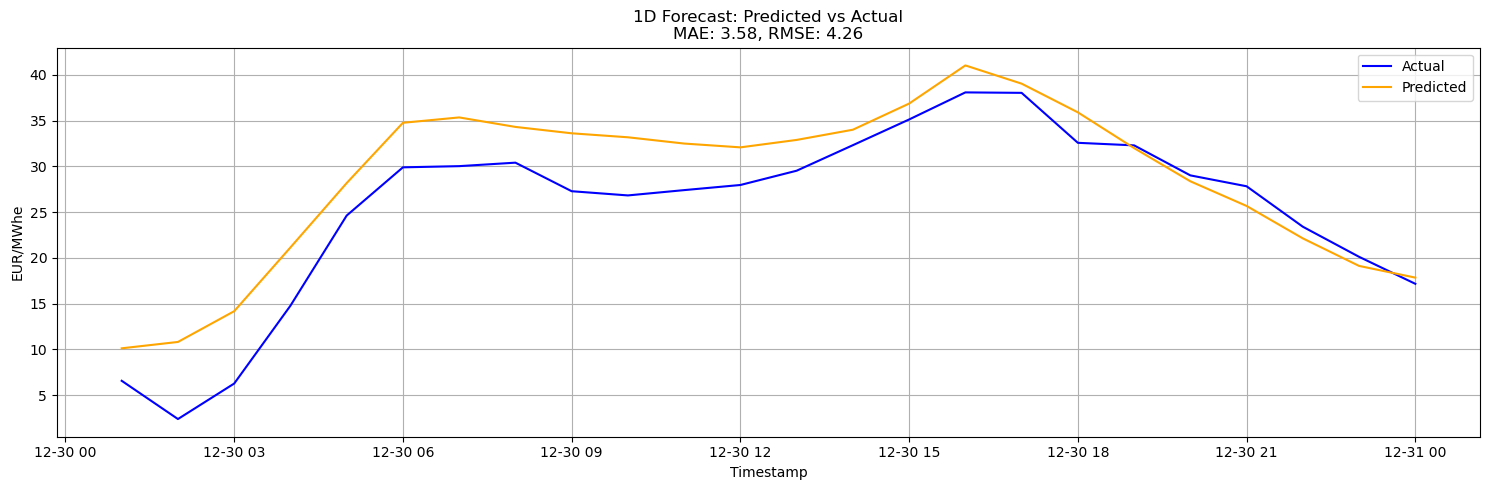


🔮 Forecasting: 7d (168 hours)...


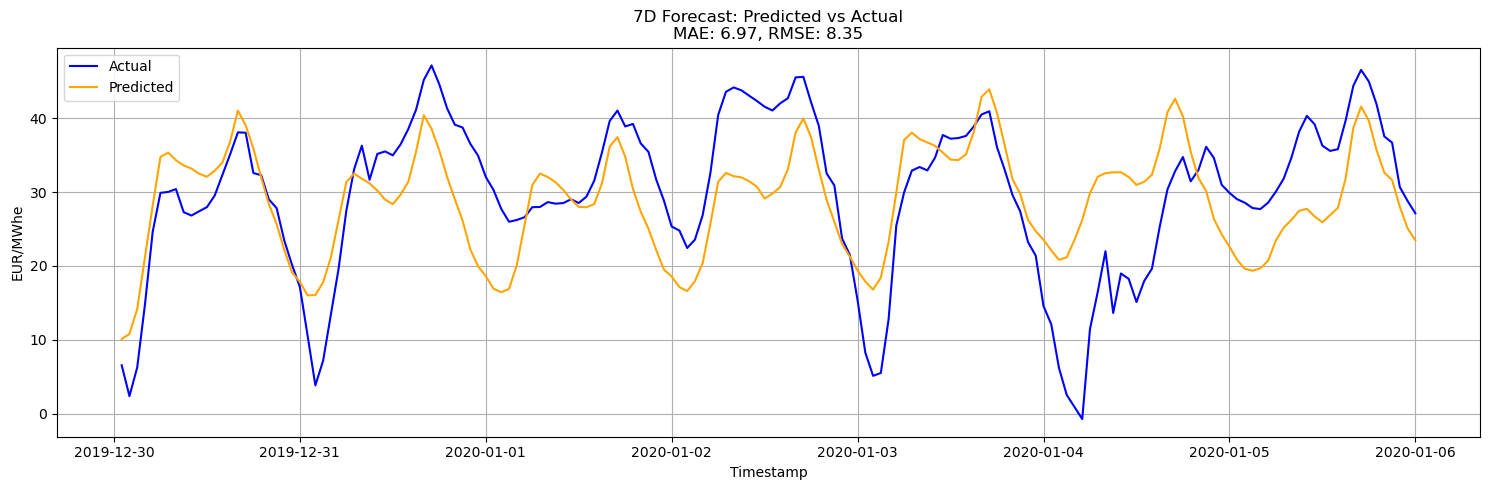


🔮 Forecasting: 1m (720 hours)...


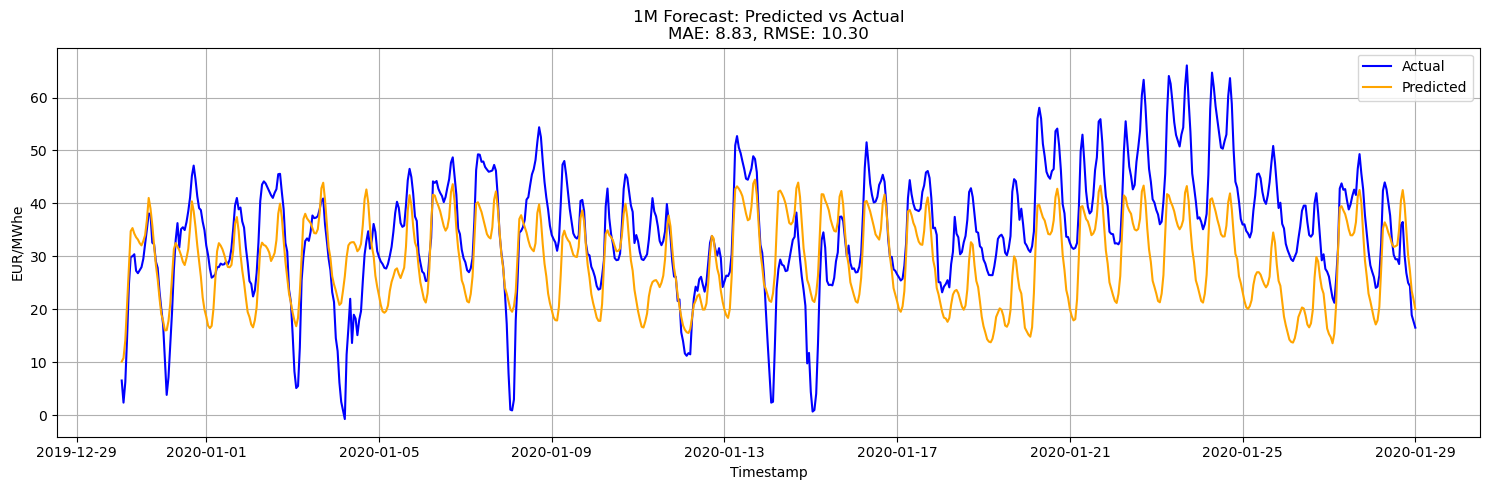


🔮 Forecasting: 3m (2160 hours)...


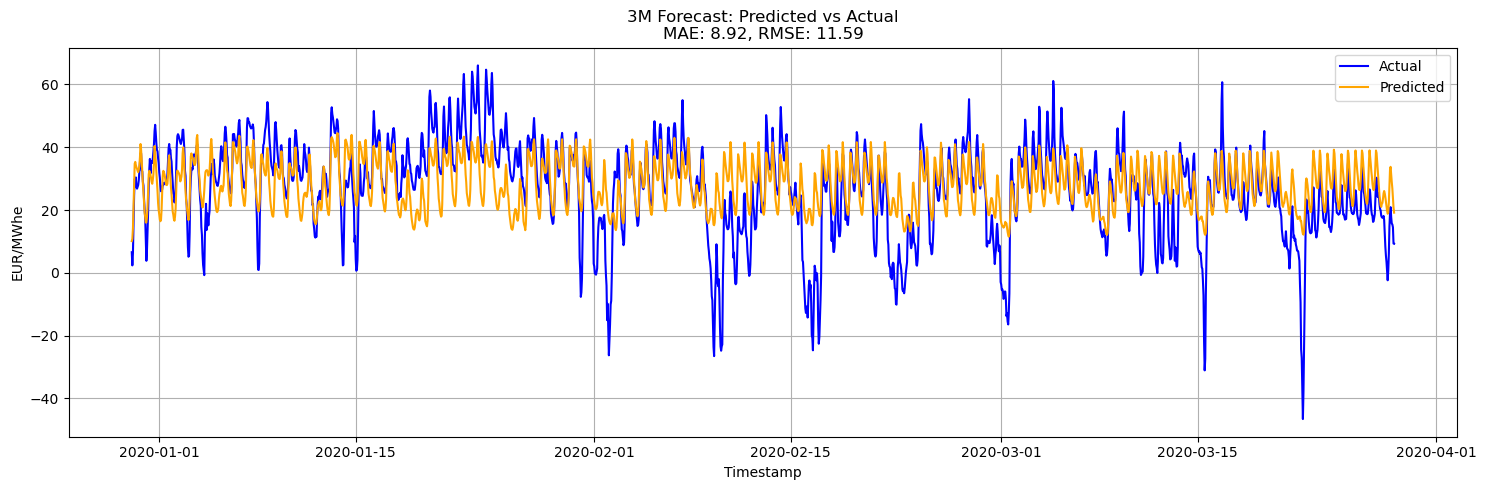


🔮 Forecasting: 6m (4320 hours)...


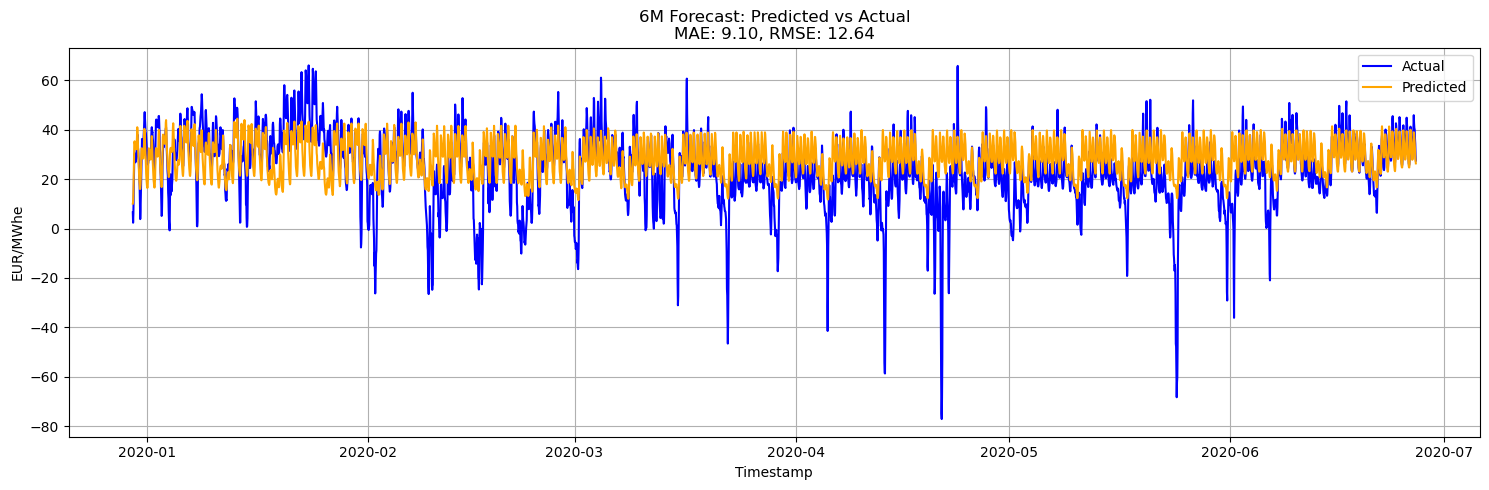


🔮 Forecasting: 12m (8760 hours)...


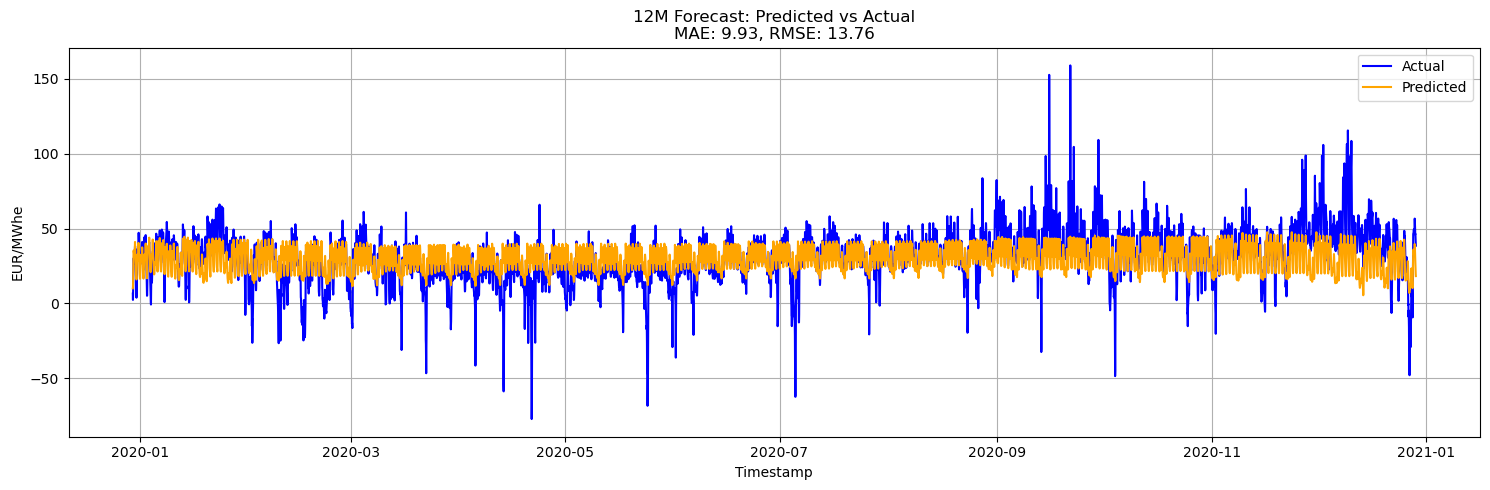

In [11]:
from datetime import timedelta

# Reload price data from full dataset
df_prices = pd.read_csv('../data/raw/Germany.csv', parse_dates=['Datetime (UTC)'])
df_prices.set_index('Datetime (UTC)', inplace=True)
df_prices = df_prices.sort_index()

# Forecast configurations
forecast_windows = {
    '1d': 24,
    '7d': 168,
    '1m': 720,
    '3m': 2160,
    '6m': 4320,
    '12m': 8760
}

results = {}

# Start from last 900 rows to give enough history
base_history = df_model.copy().iloc[-900:].copy()

for label, steps in forecast_windows.items():
    print(f"\n🔮 Forecasting: {label} ({steps} hours)...")

    last_known = base_history.copy()
    future_predictions = []

    for step in range(1, steps + 1):
        next_time = last_known.index[-1] + timedelta(hours=1)

        row = {
            'price_lag_1h': last_known[target].iloc[-1],
            'price_lag_24h': last_known[target].shift(23).iloc[-1] if len(last_known) >= 24 else np.nan,
            'price_lag_168h': last_known[target].shift(167).iloc[-1] if len(last_known) >= 168 else np.nan,
            'price_roll_24h': last_known[target].rolling(24).mean().iloc[-1] if len(last_known) >= 24 else np.nan,
            'price_roll_168h': last_known[target].rolling(168).mean().iloc[-1] if len(last_known) >= 168 else np.nan,
            'hour': next_time.hour,
            'dayofweek': next_time.dayofweek,
            'month': next_time.month
        }

        row_df = pd.DataFrame([row], index=[next_time])

        if row_df.isnull().any(axis=1).iloc[0]:
            print(f"⚠️  Skipping step {step} due to insufficient history.")
            break

        pred = model.predict(row_df[features])[0]
        row_df[target] = pred

        future_predictions.append(row_df)
        last_known = pd.concat([last_known, row_df])

    # Combine predictions
    future_df = pd.concat(future_predictions)
    future_df.rename(columns={target: 'Predicted'}, inplace=True)

    # Compare to actuals (if available)
    if future_df.index[-1] <= df_prices.index.max():
        actual = df_prices.loc[future_df.index, 'Price (EUR/MWhe)'].dropna()
        compare_df = future_df[['Predicted']].copy()
        compare_df['Actual'] = actual
        compare_df.dropna(inplace=True)

        # Metrics
        mae = mean_absolute_error(compare_df['Actual'], compare_df['Predicted'])
        rmse = np.sqrt(mean_squared_error(compare_df['Actual'], compare_df['Predicted']))

        # Store results
        results[label] = {
            'forecast': compare_df,
            'mae': mae,
            'rmse': rmse
        }

        # Plot
        plt.figure(figsize=(15, 5))
        plt.plot(compare_df.index, compare_df['Actual'], label='Actual', color='blue')
        plt.plot(compare_df.index, compare_df['Predicted'], label='Predicted', color='orange')
        plt.title(f"{label.upper()} Forecast: Predicted vs Actual\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")
        plt.xlabel('Timestamp')
        plt.ylabel('EUR/MWhe')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        print(f"⚠️  No actual data available in 'Germany.csv' for comparison for {label}.")


Now we have completed a proper forecasting of the energy prices using recursive prediction with XGBOOST </br>
The shortcomings of this method is that it dos not use the provided features and only relys on the history of the energy prices </br>
Finished by Jad Akra on Friday 19th of April 2025